In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Text processing import for Topic Modeling and Sentiment Analysis
import nltk
from IPython.core.pylabtools import figsize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Local Imports
from scripts.text_processor import TextProcessor
from scripts.news_data_plotter import NewsDataPlotter

%matplotlib inline

In [2]:
nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/leuel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
file_path = "../data/raw/raw_analyst_ratings.csv"

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [4]:
df.describe()

,Unnamed: 0
count,1.407328e+06
mean,7.072454e+05
std,4.081009e+05
min,0.000000e+00
25%,3.538128e+05
50%,7.072395e+05
75%,1.060710e+06
max,1.413848e+06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


In [6]:
df["date"] = pd.to_datetime(df["date"], format="ISO8601", utc=True)

# Create columns that will be used to aggregate the data later for the Correlation Analysis
df["date_only"] = df["date"].dt.date
df["time_only"] = df["date"].dt.time

# Set the index of the DataFrame to be the date column
df.set_index("date", inplace=True)

df.head()

,Unnamed: 0,headline,url,publisher,stock,date_only,time_only
date,,,,,,,
2020-06-05 14:30:54+00:00,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,2020-06-05,14:30:54
2020-06-03 14:45:20+00:00,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,2020-06-03,14:45:20
2020-05-26 08:30:07+00:00,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,2020-05-26,08:30:07
2020-05-22 16:45:06+00:00,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,2020-05-22,16:45:06
2020-05-22 15:38:59+00:00,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,2020-05-22,15:38:59


In [7]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,headline,url,publisher,stock,date_only,time_only
date,,,,,,
2020-06-05 14:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,2020-06-05,14:30:54
2020-06-03 14:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,2020-06-03,14:45:20
2020-05-26 08:30:07+00:00,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,2020-05-26,08:30:07
2020-05-22 16:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,2020-05-22,16:45:06
2020-05-22 15:38:59+00:00,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,2020-05-22,15:38:59


## Some Descriptive Statistics about the Data

### Analysis of News Headlines

Here I tried to understand what the news headline text length are and what the tried to categorize them as SHORT, MEDIUM, or LONG

In [8]:
#  Calculate the headline length for each news headline
df["headline_length"] = df["headline"].apply(lambda x: len(x))
df.head()

,headline,url,publisher,stock,date_only,time_only,headline_length
date,,,,,,,
2020-06-05 14:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,2020-06-05,14:30:54,39
2020-06-03 14:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,2020-06-03,14:45:20,42
2020-05-26 08:30:07+00:00,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,2020-05-26,08:30:07,29
2020-05-22 16:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,2020-05-22,16:45:06,44
2020-05-22 15:38:59+00:00,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,2020-05-22,15:38:59,87


In [9]:
#  Categorize the headlines based on their headlines to three different categories
start = df["headline_length"].min()
end = df["headline_length"].max()

bins = np.linspace(start, end, 4)

df["headline_length_category"] = pd.cut(df["headline_length"], bins=np.linspace(start, end, 4),
                                        labels=["Short", "Medium", "Long"])

df.head()

,headline,url,publisher,stock,date_only,time_only,headline_length,headline_length_category
date,,,,,,,,
2020-06-05 14:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,2020-06-05,14:30:54,39,Short
2020-06-03 14:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,2020-06-03,14:45:20,42,Short
2020-05-26 08:30:07+00:00,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,2020-05-26,08:30:07,29,Short
2020-05-22 16:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,2020-05-22,16:45:06,44,Short
2020-05-22 15:38:59+00:00,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,2020-05-22,15:38:59,87,Short


In [10]:
text_processor = TextProcessor()

# This removes stop words from the headline column to gain more meaning when calculating the sentiment scores
df["cleaned_headline"] = df["headline"].apply(text_processor.remove_stop_words)

df.head()

[nltk_data] Downloading package punkt to /home/leuel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/leuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,headline,url,publisher,stock,date_only,time_only,headline_length,headline_length_category,cleaned_headline
date,,,,,,,,,
2020-06-05 14:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,2020-06-05,14:30:54,39,Short,stocks hit 52-week highs friday
2020-06-03 14:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,2020-06-03,14:45:20,42,Short,stocks hit 52-week highs wednesday
2020-05-26 08:30:07+00:00,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,2020-05-26,08:30:07,29,Short,71 biggest movers friday
2020-05-22 16:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,2020-05-22,16:45:06,44,Short,46 stocks moving friday 's mid-day session
2020-05-22 15:38:59+00:00,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,2020-05-22,15:38:59,87,Short,b securities maintains neutral agilent technol...


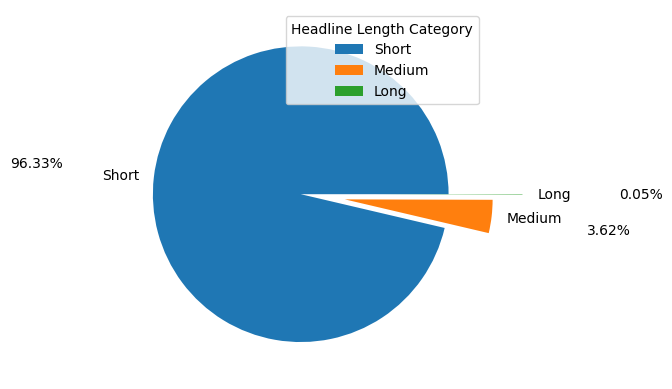

In [11]:
headline_length_category_counts = df["headline_length_category"].value_counts()

explode = [0, 0.3, 0.5]
labels = headline_length_category_counts.index
values = headline_length_category_counts.values

# Create the pie plot
fig, ax = plt.subplots()

ax.pie(values, labels=labels, autopct="%.2f%%", pctdistance=1.8, explode=explode)
ax.legend(labels, title="Headline Length Category")

# Display the plot
plt.show()

In [12]:
sia = SentimentIntensityAnalyzer()

In [13]:
df["sentiment_score"] = df["cleaned_headline"].apply(
    lambda x: sia.polarity_scores(text=x)["compound"]
)

df.head()

,headline,url,publisher,stock,date_only,time_only,headline_length,headline_length_category,cleaned_headline,sentiment_score
date,,,,,,,,,,
2020-06-05 14:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,2020-06-05,14:30:54,39,Short,stocks hit 52-week highs friday,0.000
2020-06-03 14:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,2020-06-03,14:45:20,42,Short,stocks hit 52-week highs wednesday,0.000
2020-05-26 08:30:07+00:00,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,2020-05-26,08:30:07,29,Short,71 biggest movers friday,0.000
2020-05-22 16:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,2020-05-22,16:45:06,44,Short,46 stocks moving friday 's mid-day session,0.000
2020-05-22 15:38:59+00:00,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,2020-05-22,15:38:59,87,Short,b securities maintains neutral agilent technol...,0.296


In [14]:
df["sentiment_category"] = pd.cut(
    df["sentiment_score"], bins=3, labels=["negative", "neutral", "positive"]
)

df.head()

,headline,url,publisher,stock,date_only,time_only,headline_length,headline_length_category,cleaned_headline,sentiment_score,sentiment_category
date,,,,,,,,,,,
2020-06-05 14:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,2020-06-05,14:30:54,39,Short,stocks hit 52-week highs friday,0.000,neutral
2020-06-03 14:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,2020-06-03,14:45:20,42,Short,stocks hit 52-week highs wednesday,0.000,neutral
2020-05-26 08:30:07+00:00,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,2020-05-26,08:30:07,29,Short,71 biggest movers friday,0.000,neutral
2020-05-22 16:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,2020-05-22,16:45:06,44,Short,46 stocks moving friday 's mid-day session,0.000,neutral
2020-05-22 15:38:59+00:00,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,2020-05-22,15:38:59,87,Short,b securities maintains neutral agilent technol...,0.296,neutral


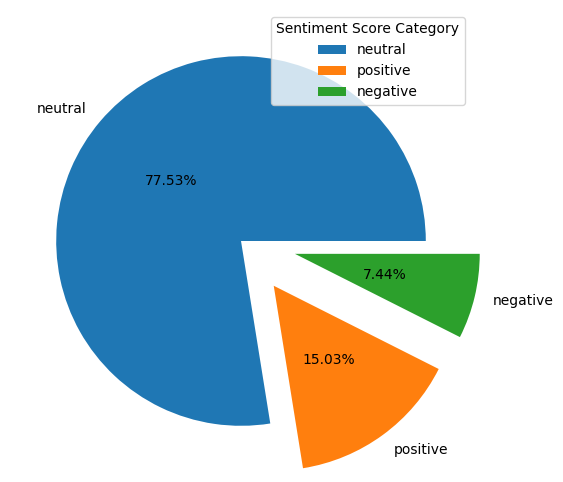

In [15]:
sentiment_category_counts = df["sentiment_category"].value_counts()

explode = [0, 0.3, 0.3]
labels = sentiment_category_counts.index
values = sentiment_category_counts.values

# Create the pie plot
_, ax = plt.subplots(figsize=(10, 6))

ax.pie(values, labels=labels, autopct="%.2f%%", pctdistance=0.5, explode=explode)
ax.legend(labels, title="Sentiment Score Category")

# Display the plot
plt.show()

### Analysis of Publication Trends

Here I tried to analyze publication trend for:
- Daily total news publication trend
- Monthly total news publication trend
- Yearly total news publication trend



In [16]:
min_date = df.index.min()
max_date = df.index.max()
difference = max_date - min_date

print(f"The data is in the range of dates from {min_date} to {max_date}")

print(
    f"The difference between dates is {difference.days} Days, which is equivalent to about {difference.days // 365} Years")

The data is in the range of dates from 2009-02-14 04:00:00+00:00 to 2020-06-11 21:12:35+00:00
The difference between dates is 4135 Days, which is equivalent to about 11 Years


#### Daily Total News Publication Trend 

In [17]:
df.columns

Index(['headline', 'url', 'publisher', 'stock', 'date_only', 'time_only',
       'headline_length', 'headline_length_category', 'cleaned_headline',
       'sentiment_score', 'sentiment_category'],
      dtype='object')

In [18]:
min_date_year = min_date.year
max_date_year = max_date.year

min_date_year, max_date_year

(2009, 2020)

In [19]:
df["date_only"] = pd.to_datetime(df["date_only"])
df["year"] = df["date_only"].dt.year
df["month"] = df["date_only"].dt.month
df["day"] = df["date_only"].dt.day

daily_news_count = df.groupby(["year", "month", "day"]).size().reset_index(name="total_news")

daily_news_count = daily_news_count.pivot_table(index=["year", "month"], columns="day", values="total_news", fill_value=0).reset_index()
daily_news_count.head(200)

day,year,month,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,2009,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
2,2009,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,3.0,0.0
3,2009,6,5.0,2.0,0.0,0.0,6.0,0.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0
4,2009,7,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,54.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,2020,2,17.0,54.0,771.0,996.0,973.0,998.0,499.0,18.0,...,23.0,121.0,955.0,1045.0,998.0,1567.0,1620.0,37.0,0.0,0.0
132,2020,3,56.0,776.0,821.0,878.0,1095.0,1428.0,27.0,48.0,...,37.0,1391.0,898.0,762.0,915.0,940.0,20.0,24.0,790.0,901.0
133,2020,4,977.0,881.0,754.0,28.0,33.0,974.0,1042.0,954.0,...,902.0,914.0,713.0,33.0,83.0,961.0,1057.0,1389.0,1327.0,0.0
134,2020,5,1088.0,48.0,130.0,894.0,1124.0,1175.0,1398.0,927.0,...,520.0,27.0,22.0,25.0,967.0,812.0,769.0,529.0,27.0,34.0


In [20]:
monthly_news_count = daily_news_count.groupby(["month", "year"]).size().reset_index()
monthly_news_count.columns = ["month", "year", "news_count"]

In [21]:
monthly_news_count = monthly_news_count.pivot_table(index="year", columns="month", values="news_count", fill_value=0)
monthly_news_count.head(200)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2009,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2010,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2013,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2015,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
